# Plotting for results

This notebook produces all results plots.
It generates some gap in the data, fill with a method (filter, MDS ...), compute metrics and then makes all relevant plots

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import altair as alt

In [ ]:
from meteo_imp.kalman.results import *
from meteo_imp.data import *
from meteo_imp.utils import *
import pandas as pd
import numpy as np
from pyprojroot import here
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import SVG, Image

from meteo_imp.kalman.results import _plot_timeseries, _get_labels
from functools import partial
from contextlib import redirect_stderr
import io

import polars as pl
from fastai.vision.data import get_grid
import cairosvg

the generation of a proper pdf is complex as `altair_render` doesn't support `XOffset`, so plotsare first renderder to svg using `vl-convert` and then to pdf using `cairosvg`. However this last methods doesn't support negative numbers ...

Due to the high number of samples also cannot use the browser render in the notebook so using `vl-convert` to a png for the visualization in the notebook

In [ ]:
import vl_convert as vlc
from pyprojroot import here
base_path_img = here("manuscript/Master Thesis - Evaluation of Kalman filter for meteorological time series imputation for Eddy Covariance applications - Simone Massaro/images/")
base_path_tbl = here("manuscript/Master Thesis - Evaluation of Kalman filter for meteorological time series imputation for Eddy Covariance applications - Simone Massaro/tables/")

base_path_img.mkdir(exist_ok=True), base_path_tbl.mkdir(exist_ok=True)

def save_show_plot(plot,
                   path,
                   altair_render=False # use altair render for pdf?
                  ):
    plt_json = plot.to_json()
    if not altair_render:
        svg_data = vlc.vegalite_to_svg(vl_spec=plt_json)
        with open(base_path_img / (path + ".svg"), 'w') as f:
            f.write(svg_data)

        cairosvg.svg2pdf(file_obj=open(base_path_img / (path + ".svg")), write_to=str(base_path_img / (path + ".pdf")))
    else:
        #save svg version anyway
        svg_data = vlc.vegalite_to_svg(vl_spec=plt_json)
        with open(base_path_img / (path + ".svg"), 'w') as f:
            f.write(svg_data)
        #convert to pdf using altair
        with redirect_stderr(io.StringIO()):
            plot.save(base_path_img / (path + ".pdf"))

    # render to image for displaying in notebook
    png_data = vlc.vegalite_to_png(vl_spec=plot.to_json(), scale=1)
    return Image(png_data)

In [ ]:
reset_seed()
n_rep = 500

In [ ]:
hai = pd.read_parquet(hai_big_path).reindex(columns=var_type.categories)
hai_era = pd.read_parquet(hai_era_big_path)

In [ ]:
alt.data_transformers.disable_max_rows() # it is safe to do so as the plots are rendered using vl-convert and then showed as images

DataTransformerRegistry.enable('default')

## Correlation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import statsmodels.api as sm

In [ ]:
def auto_corr_df(data, nlags=96):
    autocorr = {}
    for col in data.columns:
        autocorr[col] = sm.tsa.acf(data[col], nlags=nlags)
    return pd.DataFrame(autocorr)

In [ ]:
auto_corr = auto_corr_df(hai).reset_index(names="gap_len").melt(id_vars="gap_len")
auto_corr.gap_len = auto_corr.gap_len / 2

In [ ]:
auto_corr

,gap_len,variable,value
0,0.0,TA,1.000000
1,0.5,TA,0.998595
2,1.0,TA,0.995814
3,1.5,TA,0.992141
4,2.0,TA,0.987630
...,...,...,...
868,46.0,TS,0.959680
869,46.5,TS,0.961116
870,47.0,TS,0.962085
871,47.5,TS,0.962551


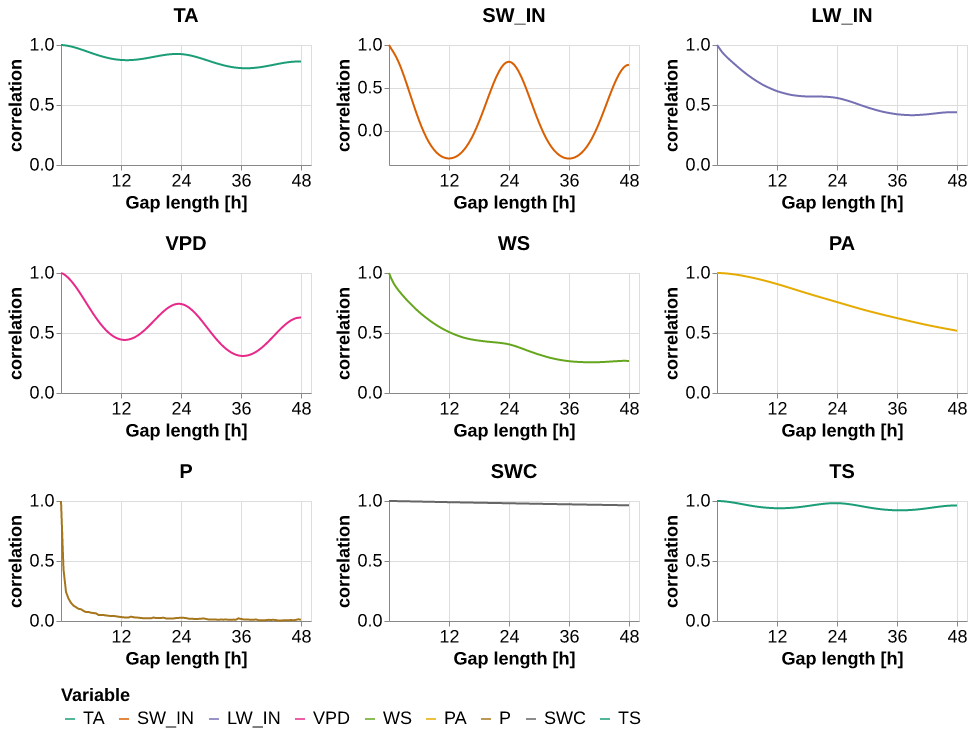

In [ ]:
p = (alt.Chart(auto_corr).mark_line().encode(
    x = alt.X('gap_len', title="Gap length [h]", axis = alt.Axis(values= [12, 24, 36, 48])),
    y = alt.Y("value", title="correlation"),
    color=alt.Color("variable", scale=meteo_scale, title="Variable"),
    facet =alt.Facet('variable', columns=3, sort = meteo_scale.domain, title=None,
                     header = alt.Header(labelFontWeight="bold", labelFontSize=20))
)
    .properties(height=120, width=250)
    .resolve_scale(y='independent', x = 'independent')
    .pipe(plot_formatter))

save_show_plot(p, "temporal_autocorrelation")

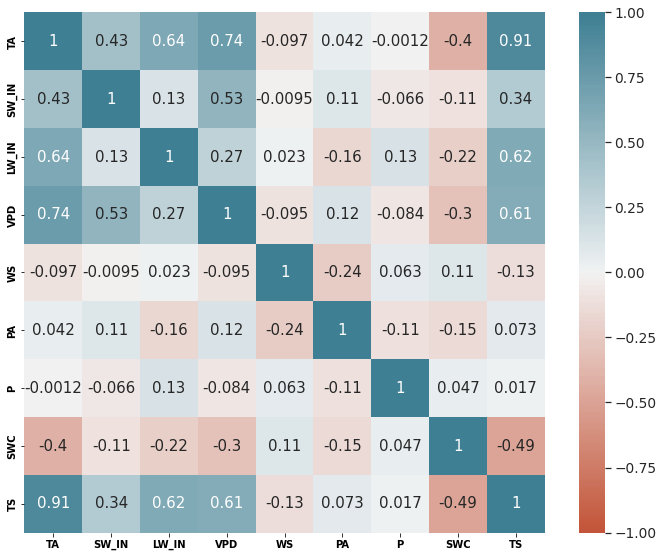

In [ ]:
axes = get_grid(1,1,1, figsize=(10,8))
sns.set(font_scale=1.25)
sns.heatmap(hai.corr(), annot=True,     vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), ax=axes[0], square=True, cbar=True)
# axes[0].set(xlabel="Variable", ylabel="Variable", title="Inter-variable Correlation");
# size_old = plt.rcParams["axes.labelsize"]
# w_old = plt.rcParams["axes.labelweight"]
# plt.rcParams["axes.labelsize"] = 30
# plt.rcParams["axes.labelweight"] = 'bold'
plt.tight_layout()
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

with matplotlib.rc_context({"axes.labelsize": 30}):
    plt.savefig(base_path_img / "correlation.pdf")
    plt.show()

# plt.rcParams["axes.labelsize"] = size_old
# plt.rcParams["axes.labelweight"] = w_old

## Comparison Imputation methods

In [ ]:
base_path = here("analysis/results/trained_models")

In [ ]:
def l_model(x, base_path=base_path): return torch.load(base_path / x)

In [ ]:
models_var = pd.DataFrame.from_records([
    {'var': 'TA',    'model': l_model("TA_specialized_gap_6-336_v3_0.pickle",base_path)},
    {'var': 'SW_IN', 'model': l_model("SW_IN_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'LW_IN', 'model': l_model("LW_IN_specialized_gap_6-336_v1.pickle",base_path)},
    {'var': 'VPD',   'model': l_model("VPD_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'WS',    'model': l_model("WS_specialized_gap_6-336_v1.pickle",base_path)},
    {'var': 'PA',    'model': l_model("PA_specialized_gap_6-336_v3_0.pickle",base_path)},
    {'var': 'P',     'model': l_model("1_gap_varying_6-336_v3.pickle",base_path)},
    {'var': 'TS',    'model': l_model("TS_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'SWC',   'model': l_model("SWC_specialized_gap_6-336_v2_1.pickle",base_path)},
])

In [ ]:
@cache_disk(cache_dir / "the_results")
def get_the_results(n_rep=20):
    reset_seed()
    comp_Av = ImpComparison(models = models_var, df = hai, control = hai_era, block_len = 446, time_series=False)
    results_Av = comp_Av.compare(gap_len = [12,24, 48, 336], var=list(hai.columns), n_rep=n_rep) 
    return results_Av

results_Av = get_the_results(n_rep)

### State of the art 

the first plot is a time series using only state-of-the-art methods

In [ ]:
reset_seed()
comp_ts = ImpComparison(models = models_var, df = hai, control = hai_era, block_len = 48+100, time_series=True, rmse=False)
results_ts = comp_ts.compare(gap_len = [48], var=list(hai.columns), n_rep=1) 

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
res_ts = results_ts.query("method != 'Kalman Filter'")
res_ts_plot = pd.concat([unnest_predictions(row, ctx_len=72) for _,row in res_ts.iterrows()])

In [ ]:
scale_sota = alt.Scale(domain=["ERA-I", "MDS"], range=list(sns.color_palette('Dark2', 3).as_hex())[1:])

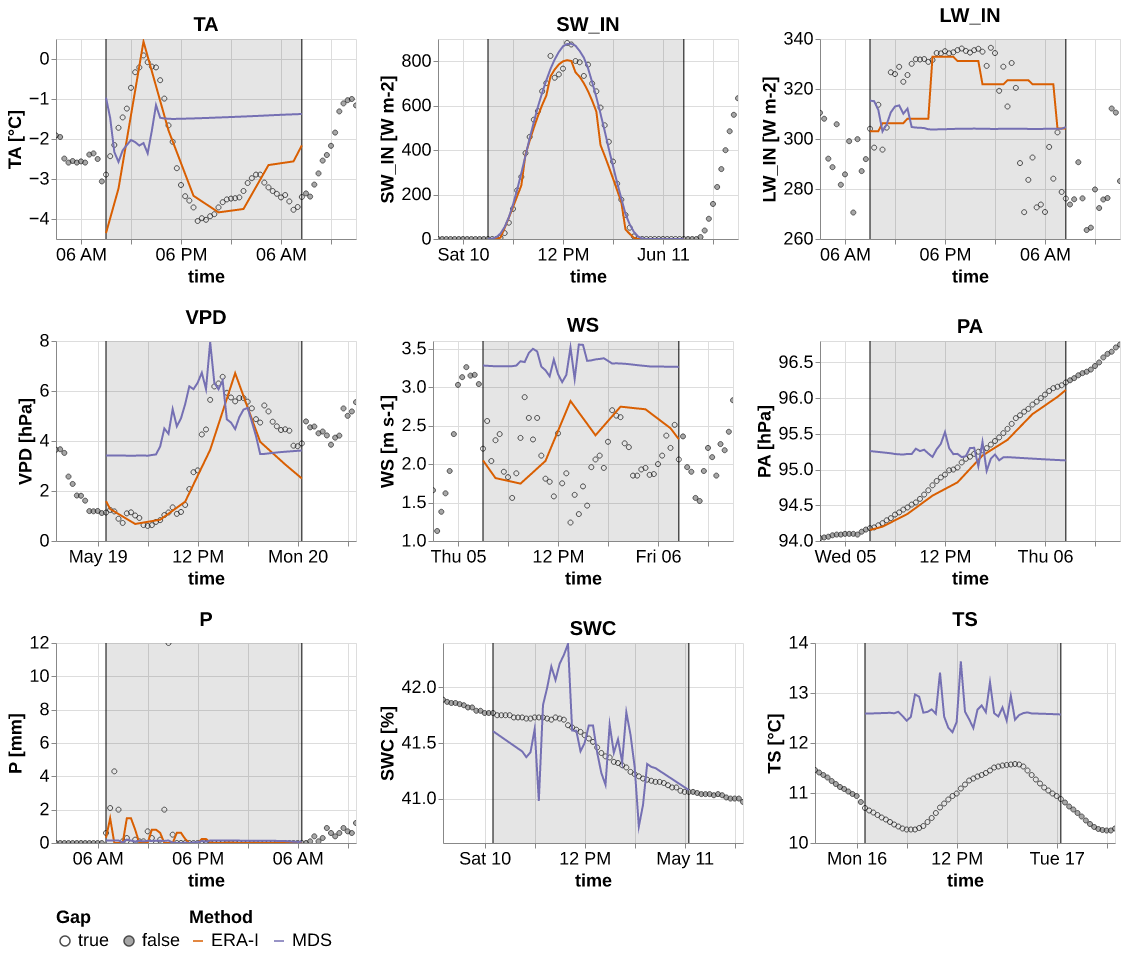

In [ ]:
p = (facet_wrap(res_ts_plot, partial(_plot_timeseries, scale_color=scale_sota, err_band = False), col="var",
                y_labels = _get_labels(res_ts_plot, 'mean', None),
               )
            .pipe(plot_formatter)
    )
save_show_plot(p, "timeseries_sota", altair_render=True)

### Percentage improvement

In [ ]:
results_Av.method.unique()

['Kalman Filter', 'ERA-I', 'MDS']
Categories (3, object): ['Kalman Filter' < 'ERA-I' < 'MDS']

In [ ]:
all_res = results_Av.query('var != "P"').groupby(['method']).agg({'rmse_stand': 'mean'}).T

In [ ]:
all_res

method,Kalman Filter,ERA-I,MDS
rmse_stand,0.204628,0.307361,0.482837


percentage of improvement across all variables

In [ ]:
(all_res["ERA-I"] - all_res["Kalman Filter"]) / all_res["ERA-I"] * 100 

rmse_stand    33.42398
dtype: float64

In [ ]:
(all_res["MDS"] - all_res["Kalman Filter"]) / all_res["MDS"] * 100 

rmse_stand    57.619542
dtype: float64

In [ ]:
res_var = results_Av.groupby(['method', 'var']).agg({'rmse_stand': 'mean'}) 

In [ ]:
res_var = res_var.reset_index().pivot(columns='method', values='rmse_stand', index='var')

In [ ]:
pd.DataFrame({'ERA': (res_var["ERA-I"] - res_var["Kalman Filter"]) / res_var["ERA-I"] * 100, 'MDS': (res_var["MDS"] - res_var["Kalman Filter"]) / res_var["MDS"] * 100 })

,ERA,MDS
var,,
TA,54.540802,77.713711
SW_IN,12.004508,35.516142
LW_IN,5.166063,52.289627
VPD,44.402821,65.407769
WS,21.064305,40.321732
PA,28.784191,90.751559
P,-18.544370,-22.084360
SWC,NaN,41.543006
TS,NaN,25.772326


In [ ]:
res_var2 = results_Av.groupby(['method', 'var', 'gap_len']).agg({'rmse_stand': 'mean'}) 

In [ ]:
res_var2 = res_var2.reset_index().pivot(columns='method', values='rmse_stand', index=['var', 'gap_len'])

In [ ]:
pd.DataFrame({'ERA': (res_var2["ERA-I"] - res_var2["Kalman Filter"]) / res_var2["ERA-I"] * 100, 'MDS': (res_var2["MDS"] - res_var2["Kalman Filter"]) / res_var2["MDS"] * 100 })

ERA        MDS
var   gap_len                      
TA    6        69.897582  85.052698
      12       58.766166  79.376385
      24       51.538443  75.395970
      168      41.823614  73.000401
SW_IN 6         9.519984  29.746651
      12       11.165399  30.639223
      24       14.232051  34.811941
      168      12.305658  42.651906
LW_IN 6        21.023524  59.136518
      12        9.110040  52.211404
      24       -3.553292  50.720632
      168      -4.260023  48.223005
VPD   6        66.980942  79.449579
      12       47.785633  69.081018
      24       33.663749  56.728120
      168      32.272332  57.702579
WS    6        32.402977  45.724043
      12       25.209162  43.275430
      24       15.543672  37.142502
      168      12.735569  36.436106
PA    6        39.823585  91.511486
      12       30.995845  90.532461
      24       24.727301  89.319180
      168      20.691181  91.421434
P     6       -18.485009 -13.917879
      12      -28.935358 -37.127331
      24      -24.423076 -29.998707
      168      -7.725322 -11.587796
SWC   6              NaN  61.302664
      12             NaN  47.976950
      24             NaN  42.535719
      168            NaN  23.301469
TS    6              NaN  64.264901
      12             NaN  46.699870
      24             NaN  27.050291
      168            NaN -15.268479

### Main plot

In [ ]:
from itertools import product
import altair as alt

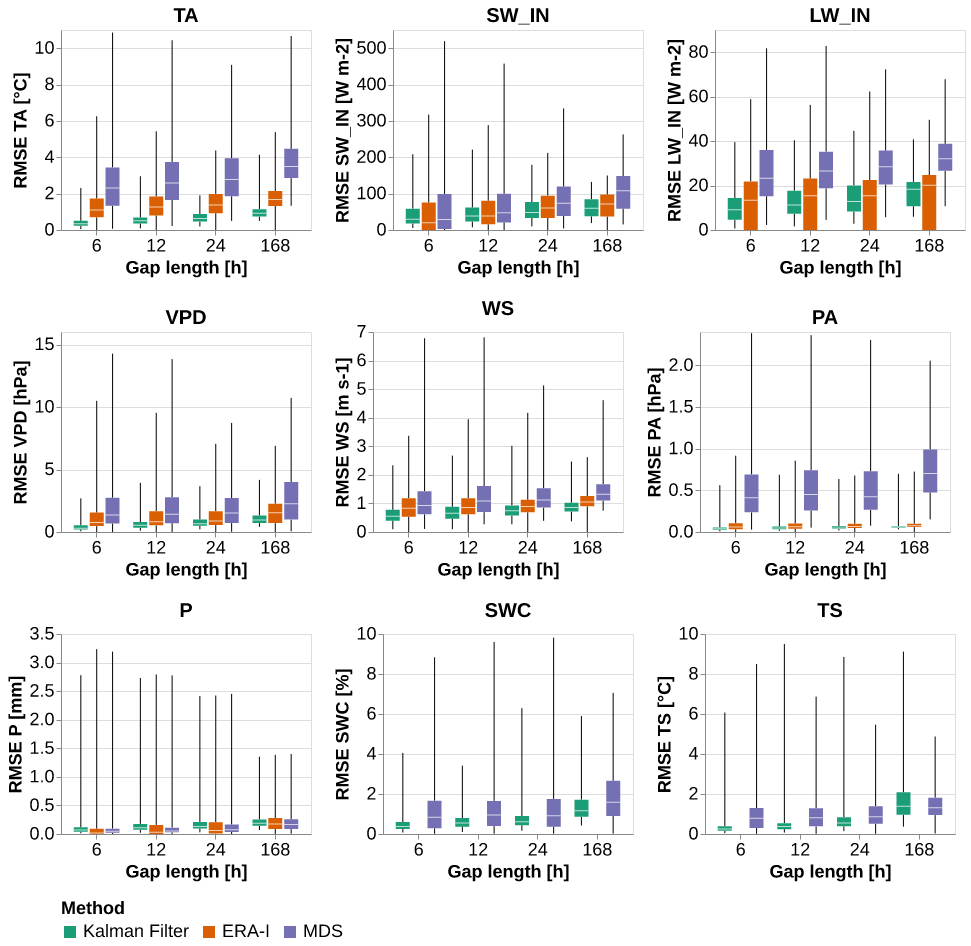

In [ ]:
p = the_plot(results_Av)
save_show_plot(p, "the_plot")

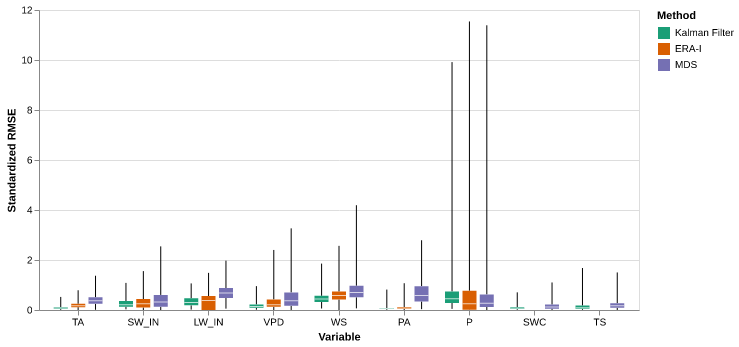

In [ ]:
p = the_plot_stand(results_Av)
save_show_plot(p, "the_plot_stand")


### Table 

In [ ]:
t = the_table(results_Av)
the_table_latex(t, base_path_tbl / "the_table.tex", label="tbl:the_table",
                caption="\\CapTheTable")
t

Kalman Filter                 ERA-I             \
RMSE                             mean        std       mean        std   
Variable Gap                                                             
TA       6 h                 0.405453   0.258301   1.346910   0.997843   
         12 h                0.606836   0.400849   1.471695   0.900611   
         1 day (24 h)        0.741275   0.368468   1.529614   0.800256   
         1 week (168 h)      1.020608   0.444591   1.754334   0.643160   
SW_IN    6 h                44.636609  40.464629  49.333113  66.241975   
         12 h               48.155186  33.868178  54.207691  49.769296   
         1 day (24 h)       56.564277  30.042752  65.950367  40.930505   
         1 week (168 h)     61.582820  25.740161  70.224393  34.883199   
LW_IN    6 h                10.902409   7.736087  13.804628  12.987987   
         12 h               13.421656   7.734502  14.766929  12.584725   
         1 day (24 h)       14.593819   7.840046  14.093052  12.227900   
         1 week (168 h)     17.062880   6.425136  16.365697  11.129569   
VPD      6 h                 0.428187   0.363168   1.296787   1.547397   
         12 h                0.660623   0.504761   1.265213   1.288794   
         1 day (24 h)        0.827563   0.501975   1.247527   1.032319   
         1 week (168 h)      1.125680   0.633392   1.662069   1.127314   
WS       6 h                 0.616774   0.316972   0.912428   0.508295   
         12 h                0.715412   0.350974   0.956550   0.524247   
         1 day (24 h)        0.801851   0.343378   0.949427   0.446912   
         1 week (168 h)      0.950211   0.363124   1.088887   0.348541   
PA       6 h                 0.045046   0.034294   0.074856   0.061726   
         12 h                0.053359   0.041613   0.077328   0.058476   
         1 day (24 h)        0.059481   0.038666   0.079021   0.051491   
         1 week (168 h)      0.066325   0.047544   0.083628   0.053654   
P        6 h                 0.134093   0.274033   0.113173   0.315504   
         12 h                0.178871   0.295419   0.138729   0.297227   
         1 day (24 h)        0.206231   0.253588   0.165750   0.288432   
         1 week (168 h)      0.239885   0.173820   0.222682   0.201782   
SWC      6 h                 0.508379   0.487342        NaN        NaN   
         12 h                0.664855   0.471849        NaN        NaN   
         1 day (24 h)        0.779066   0.640996        NaN        NaN   
         1 week (168 h)      1.493784   0.947799        NaN        NaN   
TS       6 h                 0.341080   0.431992        NaN        NaN   
         12 h                0.534363   0.783787        NaN        NaN   
         1 day (24 h)        0.786670   0.851931        NaN        NaN   
         1 week (168 h)      1.659875   1.077782        NaN        NaN   

                                MDS             
RMSE                           mean        std  
Variable Gap                                    
TA       6 h               2.712546   1.896914  
         12 h              2.942435   1.748131  
         1 day (24 h)      3.012819   1.611311  
         1 week (168 h)    3.780087   1.315472  
SW_IN    6 h              63.536627  85.401585  
         12 h             69.427115  68.936352  
         1 day (24 h)     86.770917  59.603564  
         1 week (168 h)  107.384249  53.606111  
LW_IN    6 h              26.680077  15.022366  
         12 h             28.085478  13.457335  
         1 day (24 h)     29.614461  12.416763  
         1 week (168 h)   32.954558   8.833972  
VPD      6 h               2.083592   2.149288  
         12 h              2.136626   2.095549  
         1 day (24 h)      1.912472   1.605013  
         1 week (168 h)    2.661345   1.965431  
WS       6 h               1.136367   0.783146  
         12 h              1.261203   0.796744  
         1 day (24 h)      1.275665   0.608630  
         1 week (168 h)    1.494891   0.615371  
PA       6

In [ ]:
t = the_table(results_Av, 'rmse_stand', y_name="Stand. RMSE")
the_table_latex(t, base_path_tbl / "the_table_stand.tex", stand = True, label="tbl:the_table_stand", 
                caption = "\\CapTheTableStand")
t

Kalman Filter               ERA-I                 MDS  \
Stand. RMSE                      mean       std      mean       std      mean   
Variable Gap                                                                    
TA       6 h                 0.051164  0.032595  0.169965  0.125917  0.342294   
         12 h                0.076576  0.050583  0.185712  0.113647  0.371303   
         1 day (24 h)        0.093541  0.046497  0.193021  0.100984  0.380185   
         1 week (168 h)      0.128790  0.056103  0.221378  0.081160  0.477006   
SW_IN    6 h                 0.218804  0.198354  0.241826  0.324711  0.311450   
         12 h                0.236052  0.166018  0.265721  0.243964  0.340325   
         1 day (24 h)        0.277272  0.147267  0.323282  0.200637  0.425342   
         1 week (168 h)      0.301873  0.126176  0.344233  0.170994  0.526387   
LW_IN    6 h                 0.259855  0.184387  0.329028  0.309564  0.635910   
         12 h                0.319900  0.184349  0.351964  0.299952  0.669407   
         1 day (24 h)        0.347838  0.186865  0.335903  0.291448  0.705850   
         1 week (168 h)      0.406688  0.153141  0.390071  0.265269  0.785460   
VPD      6 h                 0.098019  0.083135  0.296855  0.354224  0.476967   
         12 h                0.151227  0.115548  0.289627  0.295025  0.489108   
         1 day (24 h)        0.189442  0.114910  0.285579  0.236314  0.437795   
         1 week (168 h)      0.257686  0.144994  0.380474  0.258060  0.609224   
WS       6 h                 0.379454  0.195008  0.561347  0.312715  0.699120   
         12 h                0.440138  0.215927  0.588492  0.322529  0.775922   
         1 day (24 h)        0.493318  0.211254  0.584110  0.274951  0.784819   
         1 week (168 h)      0.584592  0.223403  0.669909  0.214431  0.919692   
PA       6 h                 0.052675  0.040103  0.087534  0.072180  0.620545   
         12 h                0.062397  0.048661  0.090425  0.068381  0.659061   
         1 day (24 h)        0.069556  0.045215  0.092405  0.060212  0.651223   
         1 week (168 h)      0.077558  0.055597  0.097793  0.062741  0.904092   
P        6 h                 0.478431  0.977725  0.403790  1.125691  0.419979   
         12 h                0.638197  1.054031  0.494974  1.060481  0.465404   
         1 day (24 h)        0.735816  0.904779  0.591382  1.029100  0.566018   
         1 week (168 h)      0.855891  0.620173  0.794512  0.719941  0.767011   
SWC      6 h                 0.057037  0.054677       NaN       NaN  0.147393   
         12 h                0.074593  0.052939       NaN       NaN  0.143384   
         1 day (24 h)        0.087407  0.071916       NaN       NaN  0.152106   
         1 week (168 h)      0.167594  0.106338       NaN       NaN  0.218510   
TS       6 h                 0.060276  0.076342       NaN       NaN  0.168674   
         12 h                0.094433  0.138512       NaN       NaN  0.177172   
         1 day (24 h)        0.139021  0.150554       NaN       NaN  0.190571   
         1 week (168 h)      0.293335  0.190466       NaN       NaN  0.254479   

                                   
Stand. RMSE                   std  
Variable Gap                       
TA       6 h             0.239370  
         12 h            0.220595  
         1 day (24 h)    0.203330  
         1 week (168 h)  0.165998  
SW_IN    6 h             0.418630  
         12 h            0.337919  
         1 day (24 h)    0.292171  
         1 week (168 h)  0.262772  
LW_IN    6 h             0.358053  
         12 h            0.320751  
         1 day (24 h)    0.295949  
         1 week (168 h)  0.210555  
VPD      6 h             0.492006  
         12 h            0.479704  
         1 day (24 h)    0.367413  
         1 week (168 h)  0.449918  
WS       6 h             0.481810  
         12 h            0.490176  
         1 day (24 h)    0.374443  
         1 week (168 h)  0.378591  
PA       6 h             0.516250  


### Timeseries

In [ ]:
@cache_disk(cache_dir / "the_results_ts")
def get_the_results_ts():
    reset_seed()
    comp_Av = ImpComparison(models = models_var, df = hai, control = hai_era, block_len = 446, time_series=True, rmse=False)
    results_Av = comp_Av.compare(gap_len = [12,24, 336], var=list(hai.columns), n_rep=4) 
    return results_Av

results_ts = get_the_results_ts()

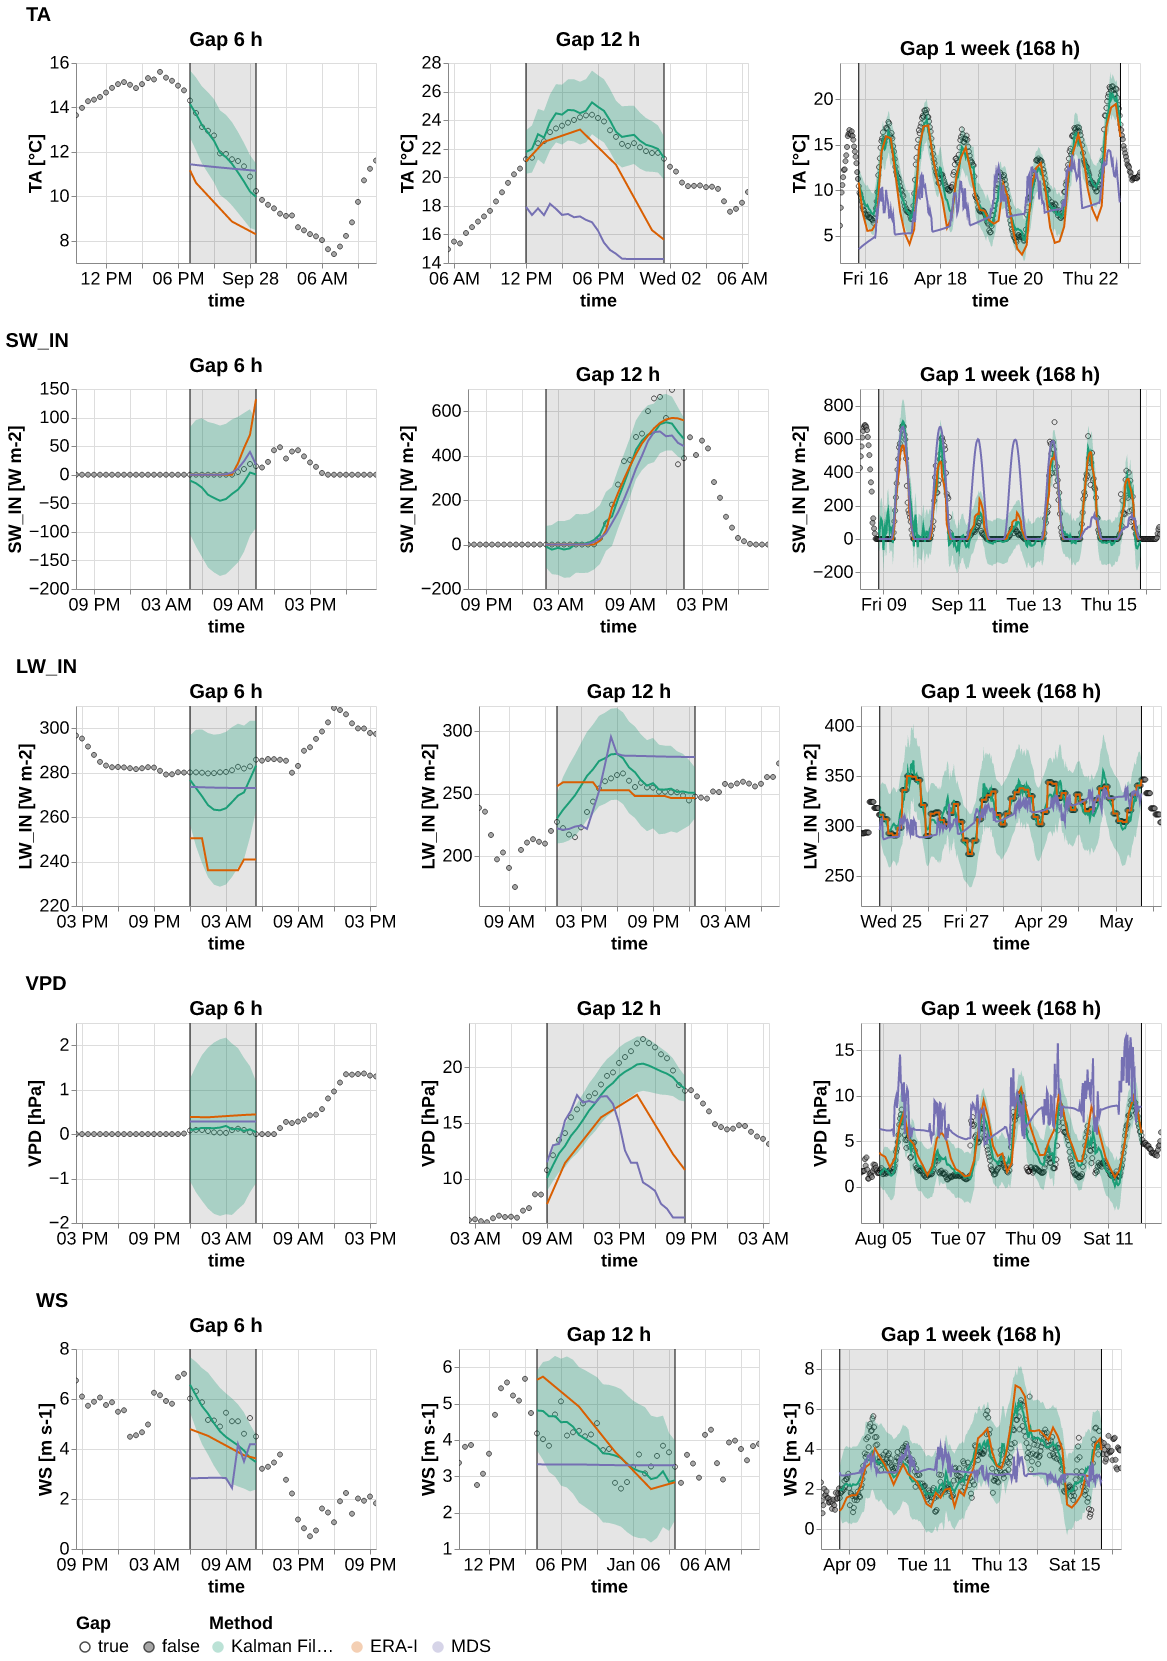

In [ ]:
ts = plot_timeseries(results_ts.query("var in ['TA', 'SW_IN', 'LW_IN', 'VPD', 'WS']"), idx_rep=0)
save_show_plot(ts, "timeseries_1", altair_render=True)

CPU times: user 2.82 s, sys: 765 µs, total: 2.82 s
Wall time: 2.84 s
CPU times: user 9.53 s, sys: 127 ms, total: 9.66 s
Wall time: 12.8 s


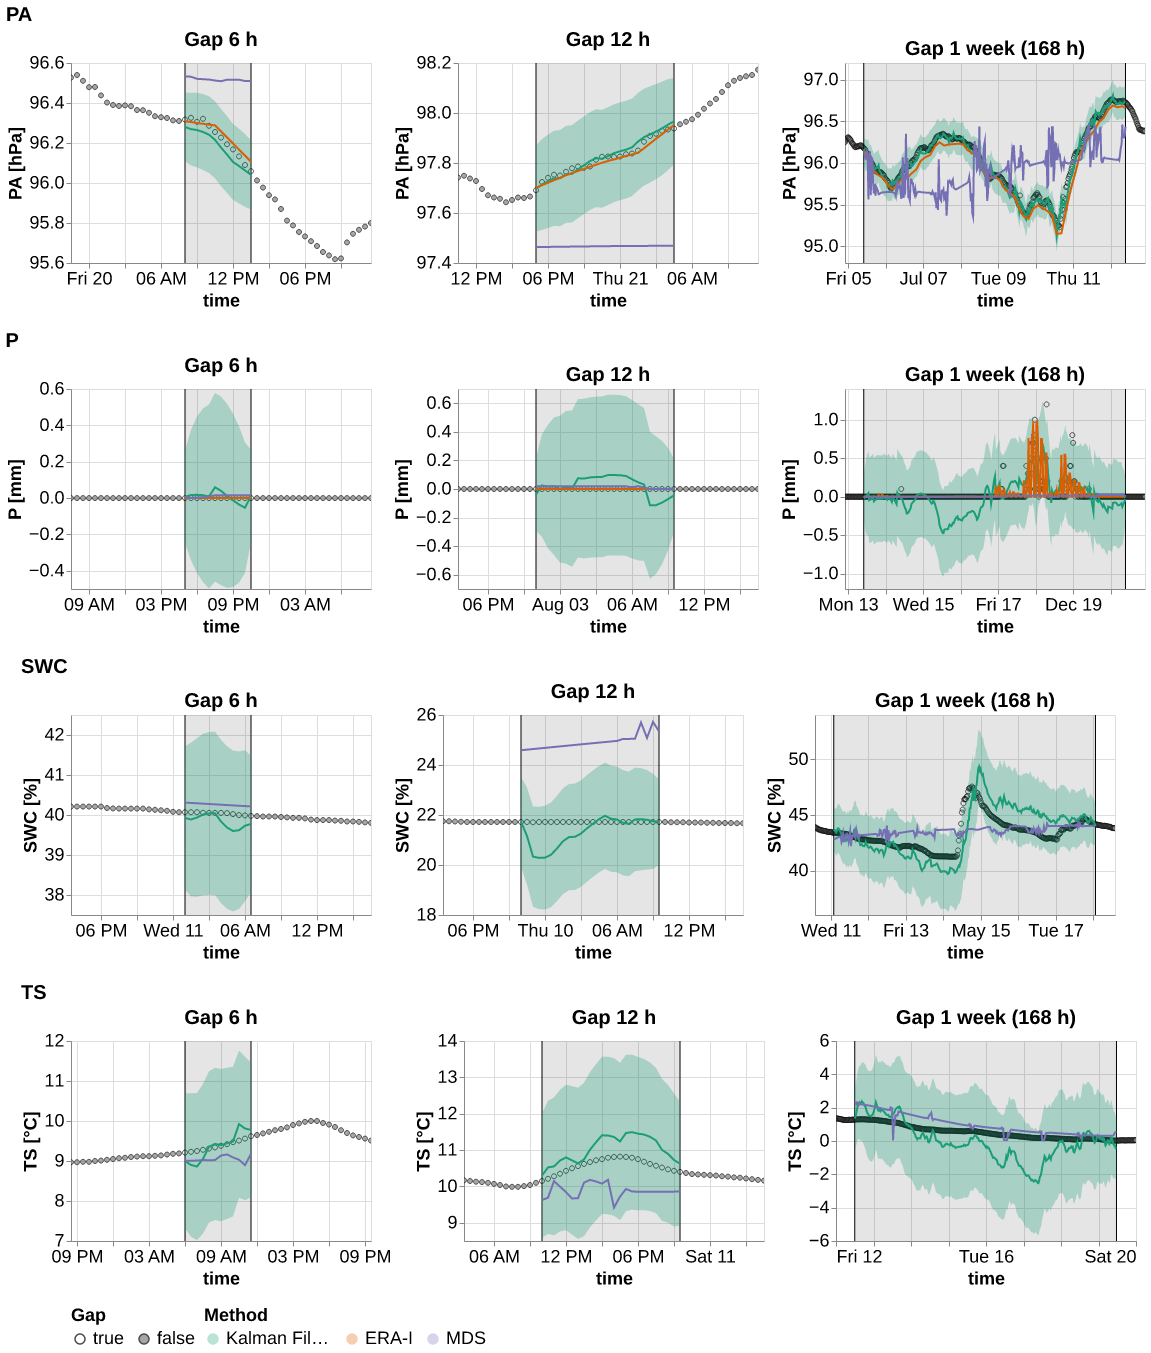

In [ ]:
%time ts = plot_timeseries(results_ts.query("var in ['PA', 'P', 'TS', 'SWC']"), idx_rep=0)
%time save_show_plot(ts, "timeseries_2", altair_render=True)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
# @cache_disk(cache_dir / "ts_plot", rm_cache=True)
def plot_additional_ts():
    for idx in tqdm(results_ts.idx_rep.unique()):
        if idx == 0: continue # skip first plot as is done above
        ts1 = plot_timeseries(results_ts.query("var in ['TA', 'SW_IN', 'LW_IN', 'VPD', 'WS']"), idx_rep=idx)
        save_show_plot(ts1, f"timeseries_1_{idx}", altair_render=True)
        ts2 = plot_timeseries(results_ts.query("var in ['PA', 'P', 'TS', 'SWC']"), idx_rep=idx)
        save_show_plot(ts2, f"timeseries_2_{idx}", altair_render=True)        

In [ ]:
plot_additional_ts()

  0%|          | 0/4 [00:00<?, ?it/s]

## Kalman Filter analysis

### Gap len

In [ ]:
@cache_disk(cache_dir / "gap_len")
def get_g_len(n_rep=n_rep):
    reset_seed()
    return KalmanImpComparison(models_var, hai, hai_era, block_len=48*7+100).compare(gap_len = [2,6,12,24,48,48*2, 48*3, 48*7], var=list(hai.columns), n_rep=n_rep)

In [ ]:
gap_len = get_g_len(n_rep)

  0%|          | 0/72 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
p = plot_gap_len(gap_len, hai, hai_era)
save_show_plot(p, "gap_len")

In [ ]:
t = table_gap_len(gap_len)
table_gap_len_latex(t, base_path_tbl / "gap_len.tex", label="gap_len",
                caption="\\CapGapLen")
t

In [ ]:
g_len_agg = gap_len.groupby('gap_len').agg({'rmse_stand': 'mean'})
(g_len_agg.iloc[0])/g_len_agg.iloc[-1]

In [ ]:
g_len_agg = gap_len.groupby(['gap_len', 'var']).agg({'rmse_stand': 'mean'})
(g_len_agg.loc[1.])/g_len_agg.loc[168.]

In [ ]:
g_len_agg

In [ ]:
g_len_agg_std = gap_len.groupby('gap_len').agg({'rmse_stand': 'std'})
(g_len_agg_std.iloc[0])/g_len_agg_std.iloc[-1]

In [ ]:
(gap_len.groupby(['gap_len', 'var']).agg({'rmse_stand': 'std'})
    .unstack("var")
    .droplevel(0, 1) 
    .plot(subplots=True, layout=(3,3), figsize=(10,10)))

In [ ]:
# with open(base_path_tbl / "gap_len.tex") as f:
    # print(f.readlines())

### Control

In [ ]:
models_nc = pd.DataFrame({'model': [ l_model("1_gap_varying_336_no_control_v1.pickle"), l_model("1_gap_varying_6-336_v3.pickle")],
                          'type':   [ 'No Control',                                       'Use Control'                         ]})                                        

In [ ]:
@cache_disk(cache_dir / "use_control")
def get_control(n_rep=n_rep):
    reset_seed()
    
    kcomp_control = KalmanImpComparison(models_nc, hai, hai_era, block_len=100+48*7)

    k_results_control = kcomp_control.compare(n_rep =n_rep, gap_len = [12, 24, 48, 48*7], var = list(hai.columns))
    
    return k_results_control

In [ ]:
from time import sleep

In [ ]:
k_results_control = get_control(n_rep)

In [ ]:
k_results_control

In [ ]:
p = plot_compare(k_results_control, 'type', y = 'rmse', scale_domain=["Use Control", "No Control"])
save_show_plot(p, "use_control")
p

In [ ]:
from functools import partial

In [ ]:
t = table_compare(k_results_control, 'type')
table_compare_latex(t, base_path_tbl / "control.tex", label="tbl:control",
                caption="\\CapControl")
t

### Gap in Other variables

In [ ]:
models_gap_single = pd.DataFrame.from_records([
    {'Gap':  'All variables', 'gap_single_var': False, 'model': l_model("all_varying_gap_varying_len_6-30_v3.pickle")},
    {'Gap':  'Only one var',  'gap_single_var': True,  'model': l_model("all_varying_gap_varying_len_6-30_v3.pickle")},
])

In [ ]:
@cache_disk(cache_dir / "gap_single")
def get_gap_single(n_rep):
    kcomp_single = KalmanImpComparison(models_gap_single, hai, hai_era, block_len=130)

    return kcomp_single.compare(n_rep =n_rep, gap_len = [6, 12, 24, 30], var = list(hai.columns))

In [ ]:
res_single = get_gap_single(n_rep)

In [ ]:
p = plot_compare(res_single, "Gap", y = 'rmse', scale_domain=["Only one var", "All variables"])
save_show_plot(p, "gap_single_var")

In [ ]:
t = table_compare(res_single, 'Gap')
table_compare_latex(t, base_path_tbl / "gap_single_var.tex", caption="\\CapGapSingle", label="tbl:gap_single_var")
t

In [ ]:
res_singl_perc = res_single.groupby(['Gap', 'var', 'gap_len']).agg({'rmse_stand': 'mean'}).reset_index().pivot(columns = 'Gap', values='rmse_stand', index=['var', 'gap_len'])

In [ ]:
pd.DataFrame({'Only one var': (res_singl_perc["All variables"] - res_singl_perc["Only one var"]) / res_singl_perc["All variables"] * 100})

In [ ]:
res_singl_perc = res_single.groupby(['Gap', 'var']).agg({'rmse_stand': 'mean'}).reset_index().pivot(columns = 'Gap', values='rmse_stand', index=['var'])

In [ ]:
pd.DataFrame({'Only one var': (res_singl_perc["All variables"] - res_singl_perc["Only one var"]) / res_singl_perc["All variables"] * 100})

### Generic vs Specialized

In [ ]:
models_generic = models_var.copy()

In [ ]:
models_generic.model = l_model("1_gap_varying_6-336_v3.pickle") 
models_generic['type'] = 'Generic'

In [ ]:
models_generic

In [ ]:
models_var['type'] = 'Fine-tuned one var'

In [ ]:
models_gen_vs_spec = pd.concat([models_generic, models_var])

In [ ]:
models_gen_vs_spec

In [ ]:
@cache_disk(cache_dir / "generic")
def get_generic(n_rep=n_rep):
    reset_seed()

    comp_generic = KalmanImpComparison(models_gen_vs_spec, hai, hai_era, block_len=100+48*7)

    return comp_generic.compare(n_rep =n_rep, gap_len = [12, 24, 48, 48*7], var = list(hai.columns))
k_results_generic = get_generic(n_rep)

In [ ]:
plot_formatter.legend_symbol_size = 300

In [ ]:
p = plot_compare(k_results_generic, 'type', y = 'rmse', scale_domain=["Fine-tuned one var", "Generic"])
save_show_plot(p, "generic")
p

In [ ]:
t = table_compare(k_results_generic, 'type')
table_compare_latex(t, base_path_tbl / "generic.tex", label='tbl:generic', caption="\\CapGeneric")
t

In [ ]:
res_singl_perc = k_results_generic.groupby(['type', 'var']).agg({'rmse_stand': 'mean'}).reset_index().pivot(columns = 'type', values='rmse_stand', index=['var'])

In [ ]:
(res_singl_perc["Generic"] - res_singl_perc["Fine-tuned one var"]) / res_singl_perc["Generic"] * 100

### Training

In [ ]:
models_train = pd.DataFrame.from_records([
    # {'Train':  'All variables',  'model': l_model("All_gap_all_30_v1.pickle")  },
    {'Train':  'Only one var',   'model': l_model("1_gap_varying_6-336_v3.pickle")  },
    {'Train':  'Multi vars',     'model': l_model("all_varying_gap_varying_len_6-30_v3.pickle")  },
    {'Train':  'Random params',  'model': l_model("rand_all_varying_gap_varying_len_6-30_v4.pickle")  }
])

In [ ]:
models_train

In [ ]:
@cache_disk(cache_dir / "train")
def get_train(n_rep):
    reset_seed()
    kcomp = KalmanImpComparison(models_train, hai, hai_era, block_len=130)

    return kcomp.compare(n_rep =n_rep, gap_len = [6, 12, 24, 30], var = list(hai.columns))

In [ ]:
res_train = get_train(n_rep)

In [ ]:
res_train_agg = res_train.groupby(['Train', 'gap_len']).agg({'rmse_stand': 'mean'}).reset_index()

In [ ]:
res_train_agg

In [ ]:
p = plot_compare(res_train, "Train", y='rmse', scale_domain=["Multi vars", "Only one var", "Random params"])
save_show_plot(p, "train_compare")

In [ ]:
t = table_compare3(res_train, 'Train')
table_compare3_latex(t, base_path_tbl / "train.tex", label="tbl:train_compare", caption="\\CapTrain")
t

## Extra results

### Standard deviations

In [ ]:
hai_std = hai.std().to_frame(name='std')
hai_std.index.name = "Variable"
hai_std = hai_std.reset_index().assign(unit=[f"\\si{{{unit}}}" for unit in units_big.values()])

In [ ]:
hai_std

In [ ]:
latex = hai_std.style.hide(axis="index").format(precision=3).to_latex(hrules=True, caption="\\CapStd", label="tbl:hai_std", position_float="centering")

with open(base_path_tbl / "hai_std.tex", 'w') as f:
    f.write(latex)

### Gap distribution

In [ ]:
out_dir = here("../fluxnet/gap_stat")

In [ ]:
site_info = pl.read_parquet(out_dir / "../site_info.parquet").select([
    pl.col("start").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M"),
    pl.col("end").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M"),
    pl.col("site").cast(pl.Categorical).sort()
])

In [ ]:
def duration_n_obs(duration):
    "converts a duration into a n of fluxnet observations"
    return abs(int(duration.total_seconds() / (30 * 60)))

In [ ]:
files = out_dir.ls()
files.sort() # need to sort to match the site_info
sites = []
for i, path in enumerate(files):
    sites.append(pl.scan_parquet(path).with_columns([
        pl.lit(site_info[i, "site"]).alias("site"),
        pl.lit(duration_n_obs(site_info[i, "start"] -  site_info[i, "end"])).alias("total_obs"),
        pl.col("TIMESTAMP_END").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y%m%d%H%M").alias("end"),
    ]).drop("TIMESTAMP_END"))

gap_stat = pl.concat(sites)

In [ ]:
pl.read_parquet(files[0])

In [ ]:
gap_stat.head().collect()

In [ ]:
def plot_var_dist(var, small=False, ax=None):
    if ax is None: ax = get_grid(1)[0]
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var)
    ).filter(
        pl.col("gap_len") < 200 if small else True
    ).with_column(pl.col("gap_len") / (24 *2 * 7)).collect().to_pandas().hist("gap_len", bins=50, ax=ax)
    ax.set_title(f"{var} - { 'gaps < 200' if small else 'all gaps'}")
    if not small: ax.set_yscale('log')
    ax.set_xlabel("gap length (weeks)")
    ax.set_ylabel(f"{'Log' if not small else ''} n gaps")
    # plt.xscale('log') 

In [ ]:
plot_var_dist('TA_F_QC')

In [ ]:
color_map = dict(zip(scale_meteo.domain, list(sns.color_palette('Set2', n_colors=len(hai.columns)).as_hex())))

In [ ]:
qc_map = {
    'TA': 'TA_F_QC',
    'SW_IN': 'SW_IN_F_QC',
    'LW_IN': 'LW_IN_F_QC',
    'VPD': 'VPD_F_QC',
    'WS': 'WS_F_QC',
    'PA': 'PA_F_QC',
    'P': 'P_F_QC',
    'TS': 'TS_F_MDS_1_QC',
    'SWC': 'SWC_F_MDS_1_QC',
}

In [ ]:
def pl_in(col, values):
    expr = False
    for val in values:
        expr |= pl.col(col) == val
    return expr

In [ ]:
gap_stat.filter(pl_in('variable', qc_map.values())
               ).with_columns([
    pl.when(pl.col("gap_len") < 48*7).then(True).otherwise(False).alias("short"),
    pl.count().alias("total"),
    pl.count().alias("total len"),
]).groupby("short").agg([
    (pl.col("gap_len").count() / pl.col("total")).alias("frac_num"),
    (pl.col("gap_len").sum() / pl.col("total len")).alias("frac_len")
]).collect()

In [ ]:
gap_stat.filter(pl_in('variable', qc_map.values())
               ).with_columns([
    pl.when(pl.col("gap_len") < 48*7).then(True).otherwise(False).alias("short"),
    pl.count().alias("total"),
    pl.count().alias("total len"),
]).groupby("short").agg([
    (pl.col("gap_len").count() / pl.col("total")).alias("frac_num"),
    (pl.col("gap_len").sum() / pl.col("total len")).alias("frac_len")
]).collect()

In [ ]:
frac_miss = gap_stat.filter(
    pl_in('variable', qc_map.values())
).groupby(["site", "variable"]).agg([
    pl.col("gap_len").mean().alias("mean"),
    (pl.col("gap_len").sum() / pl.col("total_obs").first()).alias("frac_gap")
])

In [ ]:
frac_miss.groupby('variable').agg([
    pl.col("frac_gap").max().alias("max"),
    pl.col("frac_gap").min().alias("min"),
    pl.col("frac_gap").std().alias("std"),
    pl.col("frac_gap").mean().alias("mean"),
]).collect()

In [ ]:
frac_miss.sort("frac_gap", reverse=True).collect()

In [ ]:
site_info.filter((pl.col("site") == "US-LWW"))

In [ ]:
gap_stat.filter((pl.col("site") == "US-LWW") & (pl.col("variable") == "LW_IN_F_QC" )).collect()

In [ ]:
import matplotlib

In [ ]:
matplotlib.rcParams.update({'font.size': 22})
sns.set_style("whitegrid")

In [ ]:
def plot_var_dist(var, ax=None, small=True):
    if ax is None: ax = get_grid(1)[0]
    
    color = color_map[var]
    var_qc = qc_map[var]
    ta_gaps = gap_stat.filter(
        (pl.col("variable") == var_qc)
    ).filter(
        pl.col("gap_len") < (24 * 2 *7) if small else True 
    ).with_column(pl.col("gap_len") / (2 if small else 48 * 7)
                 ).collect().to_pandas().hist("gap_len", bins=50, ax=ax, edgecolor="white", color=color)
    ax.set_title(f"{var} - { 'gap length <  1 week' if small else 'all gaps'}")
    ax.set_xlabel(f"Gap length ({ 'hour' if small else 'week'})")
    ax.set_ylabel(f"Log n gaps")
    ax.set_yscale('log') 
    plt.tight_layout()

In [ ]:
vars = gap_stat.select(pl.col("variable").unique()).collect()

In [ ]:
vars.filter(pl.col("variable").str.contains("TA"))

In [ ]:
for ax, var in zip(get_grid(9,3,3, figsize=(15,12), sharey=False), list(var_type.categories)):
    plot_var_dist(var, ax=ax)
plt.savefig(base_path_img / "gap_len_dist_small.pdf")

In [ ]:
for ax, var in zip(get_grid(9,3,3, figsize=(15,12), sharey=False), list(var_type.categories)):
    plot_var_dist(var, ax=ax, small=False)
plt.savefig(base_path_img / "gap_len_dist.pdf")

### Square Root Filter

#### Numerical Stability

In [ ]:
from meteo_imp.kalman.performance import *

In [ ]:
err = cache_disk(cache_dir / "fuzz_sr")(fuzz_filter_SR)(100, 110) # this is already handling the random seed

In [ ]:
p = plot_err_sr_filter(err)
save_show_plot(p, "numerical_stability")

#### Performance

In [ ]:
@cache_disk(cache_dir / "perf_sr")
def get_perf_sr():
    reset_seed()
    return perf_comb_params('filter', use_sr_filter=[True, False], rep=range(100),
                           n_obs = 100,
                           n_dim_obs=9,
                           n_dim_state=18,
                           n_dim_contr=14,
                           p_missing=0,
                           bs=20 ,
                           init_method = 'local_slope'
                           ) 

In [ ]:
perf1 = (get_perf_sr()
    .groupby('use_sr_filter')
    .agg(pl.col("time").mean())
    .with_column(
        pl.when(pl.col("use_sr_filter"))
        .then(pl.lit("Square Root Filter"))
        .otherwise(pl.lit("Standard Filter"))
        .alias("Filter type")
    ))

In [ ]:
perf1

In [ ]:
(perf1[0, 'time'] - perf1[1, 'time']) / perf1[1, 'time'] * 100

In [ ]:
plot_perf_sr = alt.Chart(perf1.to_pandas()).mark_bar(size = 50).encode(
    x=alt.X('Filter type', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('time', scale=alt.Scale(zero=False), title="time [s]"),
    color=alt.Color('Filter type',
                    scale = alt.Scale(scheme = 'accent'))
).properties(width=300)

In [ ]:
save_show_plot(plot_perf_sr, "perf_sr")